In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

from BuoyData import BuoyDataCopernicus, TargetedTimeRange
from data_preprocessing import plot_buoy_data_time_collapsed
from ExperimentRunner import ExperimentRunner

import random
import datetime
import dateutil
import numpy as np
import folium
import pandas as pd
import netCDF4
import xarray as xr
import h5py
from folium import plugins
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# import lux
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


...Loading info from: index_platform.txt
...Loading info from: index_latest.txt
...Loading info from: index_monthly.txt
...Loading info from: index_history.txt
Num of buoys in spatio-temporal range: 94
Forecast is the same as Hindcast for OceanCurrents.


100%|██████████| 706/706 [00:06<00:00, 109.41it/s]


Percentage of failed interp: 0.0%
...Loading info from: index_platform.txt
...Loading info from: index_latest.txt
...Loading info from: index_monthly.txt
...Loading info from: index_history.txt
Num of buoys in spatio-temporal range: 94
-137.01600646972656 -120.00399780273438
21.208999633789062 29.992000579833984
2022-04-24 13:00:00 2022-05-03 13:00:00


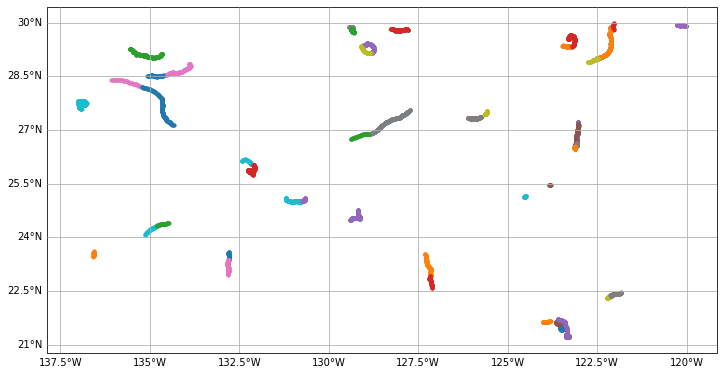

In [4]:
# get buoy data
yaml_path = "/home/jonas/Documents/Thesis/OceanPlatformControl/scenarios/generative_error_model/config_buoy_data.yaml"
ex_runner = ExperimentRunner()
buoy_data = BuoyDataCopernicus(ex_runner.config)
print(f"Num of buoys in spatio-temporal range: {len(set(buoy_data.index_data['platform_code']))}")
# print(f"Num of buoys according to download link: {len(set([link.split('/')[-1] for link in buoy_data.index_data['file_name']]))}")
print(min(buoy_data.data["lon"]), max(buoy_data.data["lon"]))
print(min(buoy_data.data["lat"]), max(buoy_data.data["lat"]))
print(min(buoy_data.data["time"]), max(buoy_data.data["time"]))
plot_buoy_data_time_collapsed(buoy_data.data)

In [5]:
# Vis location of bbox
targeted_bbox = buoy_data.targeted_bbox
x_loc = (targeted_bbox[0]+ targeted_bbox[2])/2
y_loc = (targeted_bbox[1]+ targeted_bbox[3])/2
f = folium.Figure(width=500, height=500)
m = folium.Map(location=[y_loc, x_loc], zoom_start=4).add_to(f)
points = [(targeted_bbox[1], targeted_bbox[0]), (targeted_bbox[3], targeted_bbox[2])]
folium.Rectangle(bounds=points, color='#ff7800').add_to(m)
f

### Get hincasts from opendap

In [3]:
%load_ext autoreload
%autoreload 2
from ocean_navigation_simulator.environment.data_sources.OceanCurrentField import OceanCurrentField
from ocean_navigation_simulator.utils import units
import datetime

# Create the source dict for the ocean currents
source_dict = {'field': 'OceanCurrents'}
source_dict['source'] = 'opendap'
source_dict['source_settings'] = {
                   'service': 'copernicus',
                   'currents': 'total', # if we want to take the normal uo, vo currents or 'total' for tide, normal added
                   'USERNAME': 'jdieker', 'PASSWORD': 'AxxzVqCuC#!vS69',
                   # 'DATASET_ID': 'global-analysis-forecast-phy-001-024-hourly-t-u-v-ssh',
                   'DATASET_ID': 'cmems_mod_glo_phy_anfc_merged-uv_PT1H-i'}

sim_cache_dict = {'deg_around_x_t': 1, 'time_around_x_t': 3600 * 24 * 1}

# Create the ocean Field
ocean_field = OceanCurrentField(hindcast_source_dict=source_dict, sim_cache_dict=sim_cache_dict)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Forecast is the same as Hindcast for OceanCurrents.


In [4]:
config = buoy_data.buoy_config
date_format = "%Y-%m-%dT%H:%M:%SZ"
# t_0 = datetime.datetime.strptime(config["time_range"].split("/")[0], date_format)
t_0 = dateutil.parser.isoparse(config["time_range"].split("/")[0])
t_interval = [t_0, t_0 + datetime.timedelta(days=7)]
x_interval=[config["lon_range"][0]-5, config["lon_range"][1]+5]
y_interval=[config["lat_range"][0]-3, config["lat_range"][1]+3]

# get data
# ds_hind = ocean_field.hindcast_data_source.get_data_over_area(x_interval, y_interval, t_interval)

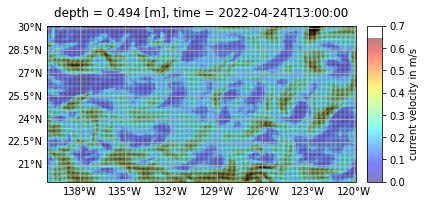

In [11]:
# plot retrieved data
ocean_field.hindcast_data_source.plot_data_at_time_over_area(
    time=t_0, x_interval=x_interval, y_interval=y_interval,
    plot_type='quiver', return_ax=False)

### Casadi based Interpolation

In [15]:
from ocean_navigation_simulator.environment.PlatformState import PlatformState
from ocean_navigation_simulator.utils import units
platform_state = PlatformState(lon=units.Distance(deg=np.mean(x_interval)), lat=units.Distance(deg=np.mean(y_interval)), date_time=t_0)
ocean_field.hindcast_data_source.update_casadi_dynamics(state=platform_state)

# convert buoy time axis to posix
df["time"] = pd.to_datetime(df["time"])
posix_timestamp = units.get_posix_time_from_np64(df["time"].values)
df["time_posix"] = posix_timestamp

In [16]:
spatio_temporal_points = np.array([df["time_posix"], df["lat"], df["lon"]]).T

import casadi as ca

for i in range(spatio_temporal_points[:10].shape[0]):
    print(f"spatio-temporal point: {spatio_temporal_points[i]}")
    interp_point_u = ocean_field.hindcast_data_source.u_curr_func(spatio_temporal_points[i])
    print(f"interpolated value: {interp_point_u}")

spatio-temporal point: [ 1.6508052e+09  2.1458000e+01 -1.2353800e+02]
interpolated value: -1.33124
spatio-temporal point: [ 1.6508088e+09  2.1455000e+01 -1.2353900e+02]
interpolated value: -0.467082
spatio-temporal point: [ 1.6508124e+09  2.1454000e+01 -1.2353800e+02]
interpolated value: 0.443184
spatio-temporal point: [ 1.650816e+09  2.145000e+01 -1.235350e+02]
interpolated value: -8.08316
spatio-temporal point: [ 1.6508196e+09  2.1445000e+01 -1.2353000e+02]
interpolated value: -18.5659
spatio-temporal point: [ 1.6508232e+09  2.1438000e+01 -1.2352600e+02]
interpolated value: -18.5999
spatio-temporal point: [ 1.6508268e+09  2.1431000e+01 -1.2351800e+02]
interpolated value: -17.6464
spatio-temporal point: [ 1.6508304e+09  2.1424000e+01 -1.2351000e+02]
interpolated value: -18.6153
spatio-temporal point: [ 1.650834e+09  2.141700e+01 -1.235010e+02]
interpolated value: -17.6647
spatio-temporal point: [ 1.6508376e+09  2.1413000e+01 -1.2349400e+02]
interpolated value: -7.00681


### Scipy based Interpolation

In [10]:
# from ocean_navigation_simulator.env.utils.units import get_posix_time_from_np64
# from scipy.interpolate import RegularGridInterpolator
# from tqdm import tqdm

# # need to convert time to posix time
# # ds = ocean_field.hindcast_data_source.DataArray
# ds = ds_hind
# posix_timestamp = [get_posix_time_from_np64(time) for time in ds["time"].values]
# ds = ds.assign_coords(time_posix=posix_timestamp)

# # define interpolation function (using hindcast coordinates and u,v)
# interp_u = RegularGridInterpolator((ds["time_posix"].values, ds["lat"].values, ds["lon"].values), ds["water_u"].values)
# # interp_v = RegularGridInterpolator((ds["time_posix"].values, ds["lat"].values, ds["lon"].values), ds["water_v"].values)

# # convert buoy time axis to posix
# df["time"] = pd.to_datetime(df["time"])
# posix_timestamp = [get_posix_time_from_np64(time) for time in df["time"].values]
# df["time_posix"] = posix_timestamp
# df["time_posix"]

# # Define points to interpolate
# points = np.array([df["time_posix"], df["lat"], df["lon"]]).T
# df["u_hind"] = 0
# df["v_hind"] = 0

# # split points into chunks
# n = 2
# for i in tqdm(range(100, points.shape[0], n)):
#     print(points[i:i+n].shape)
#     u_points = interp_u(points[i:i+n])
#     # v_points = interp_v(points[i:i+n])
#     print(u_points)
    
#     # add columns to dataframe
#     df["u_hind"][i:i+n] = u_points
#     # df["v_hind"][i:i+n] = v_points
#     break



In [71]:
from scipy.interpolate import RegularGridInterpolator
def f(x,y,z):
    return 2 * x**3 + 3 * y**2 - z
x = np.linspace(1, 4, 11)
y = np.linspace(4, 7, 22)
z = np.linspace(7, 9, 33)
data = f(*np.meshgrid(x, y, z, indexing='ij', sparse=True))

In [72]:
my_interpolating_function = RegularGridInterpolator((x, y, z), data)
pts = np.array([[2.1, 6.2, 8.3], [3.3, 5.2, 7.1]])
print(pts.shape)
my_interpolating_function(pts)

(2, 3)


array([125.80469388, 146.30069388])

### Xarray interpolation

In [5]:
# test func
from data_preprocessing import interp_xarray

df = buoy_data.interpolate_hindcast(ocean_field)

100%|██████████| 484/484 [1:10:39<00:00,  8.76s/it]

Percentage of failed interp: 0.0%


In [6]:
# remove rows containing NaNs
df_hindcast = df[df["u"].isna() == False]
df_hindcast.shape

(4767, 8)

### Save Interpolated Data

In [8]:
# save df
root = buoy_data.buoy_config["data_dir"]
df_hindcast.to_csv(os.path.join(root, "drifter_data", "current_error_2021_10.csv"), index=False)

In [15]:
# load previous csv
root = buoy_data.buoy_config["data_dir"]
df_hindcast = pd.read_csv(os.path.join(root, "drifter_data", "current_error_2021_10.csv"))
buoy_data.data = df_hindcast

### Plot Mean and RMSE

In [21]:
from generative_model_metrics import calc_speed_mean, calc_speed_RMSE, plot_metric

df_hindcast["RMSE_speed"] = calc_speed_RMSE(df_hindcast["u_hindcast"], df_hindcast["v_hindcast"], df_hindcast["u"], df_hindcast["v"])
df_hindcast["mean_speed"] = calc_speed_mean(df_hindcast["u_hindcast"], df_hindcast["v_hindcast"], df_hindcast["u"], df_hindcast["v"])
df_hindcast

,time,lon,lat,u,v,buoy,u_hindcast,v_hindcast,day,RMSE_speed,mean_speed
0,2021-10-24 13:00:00,-134.556,28.983,-0.119,-0.090,GL_TS_DC_4601715_202110,0.112441,-0.064027,2021-10-24,0.232894,0.182019
1,2021-10-24 14:00:00,-134.557,28.978,-0.136,-0.069,GL_TS_DC_4601715_202110,0.128020,-0.062372,2021-10-24,0.264103,0.191377
2,2021-10-24 15:00:00,-134.561,28.973,-0.177,-0.045,GL_TS_DC_4601715_202110,0.135596,-0.059488,2021-10-24,0.312931,0.210794
3,2021-10-24 16:00:00,-134.563,28.966,-0.220,-0.097,GL_TS_DC_4601715_202110,0.144722,-0.058199,2021-10-24,0.366780,0.285334
4,2021-10-24 17:00:00,-134.567,28.959,-0.201,-0.108,GL_TS_DC_4601715_202110,0.157117,-0.059331,2021-10-24,0.361409,0.287641
...,...,...,...,...,...,...,...,...,...,...,...
4762,2021-10-27 01:00:00,-133.154,29.976,0.278,0.066,GL_TS_DC_5501571_202110,-0.000361,0.081820,2021-10-27,0.278810,-0.185645
4763,2021-10-27 02:00:00,-133.151,29.983,0.232,0.094,GL_TS_DC_5501571_202110,0.006379,0.073402,2021-10-27,0.226559,-0.174103
4764,2021-10-27 03:00:00,-133.147,29.990,0.169,0.107,GL_TS_DC_5501571_202110,0.014496,0.067008,2021-10-27,0.159596,-0.137529
4765,2021-10-27 04:00:00,-133.143,29.996,0.139,0.107,GL_TS_DC_5501571_202110,0.013827,0.064794,2021-10-27,0.132097,-0.118355


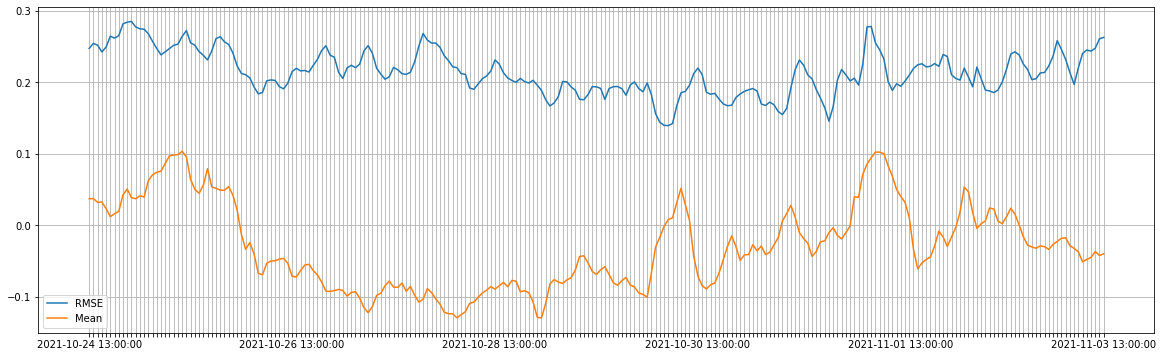

In [22]:
# mean current error vs time
# df_filt = df[df["time"] < "2021-01-07"]
df_group = df_hindcast.groupby(by=["time"], as_index=False).mean()
fig, ax = plt.subplots(figsize=(20,6))
plt.locator_params(axis='x', nbins=7)
plt.plot(df_group["time"], df_group["RMSE_speed"], label="RMSE")
plt.plot(df_group["time"], df_group["mean_speed"], label="Mean")
plt.legend()
plt.grid()

# needed to supress most labels
every_nth = 48
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.show()

### Spectral Analysis

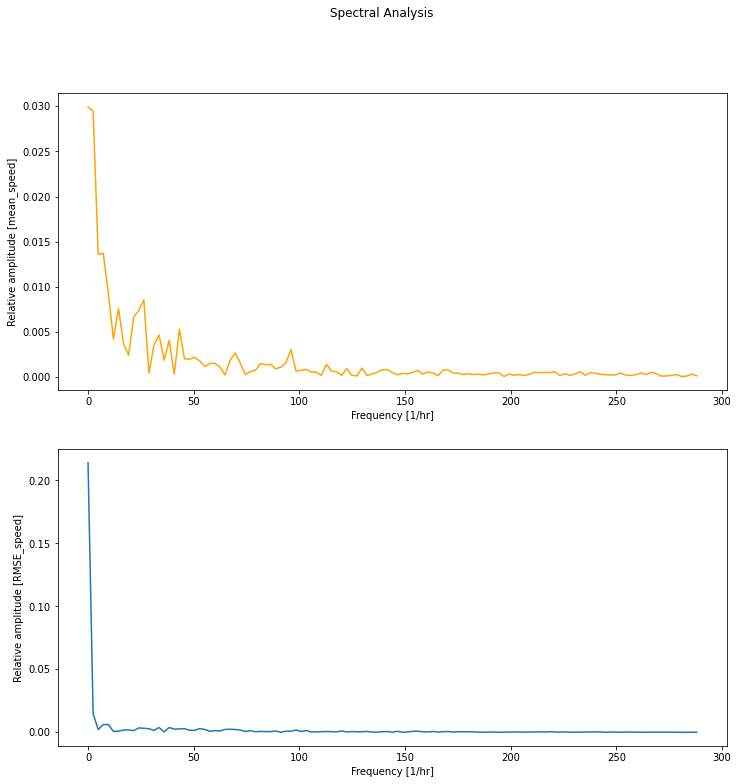

In [12]:
from scipy.fft import fft, rfftfreq

fig, axs = plt.subplots(2, figsize=(12,12))
fig.suptitle("Spectral Analysis")

metric = "mean_speed"
n = len(df_group[metric][1:])
sample_rate = 24 # measurements per day
fourier_transform = np.fft.rfft(df_group[metric][1:])/n
frequencies = rfftfreq(n, 1/sample_rate)
axs[0].plot(frequencies*24, abs(fourier_transform), color="orange")
axs[0].set_xlabel('Frequency [1/hr]')
axs[0].set_ylabel(f'Relative amplitude [{metric}]')

metric = "RMSE_speed"
n = len(df_group[metric][1:])
sample_rate = 24 # measurements per day
fourier_transform = np.fft.rfft(df_group[metric][1:])/n
frequencies = rfftfreq(n, 1/sample_rate)
axs[1].plot(frequencies*24, abs(fourier_transform))
axs[1].set_xlabel('Frequency [1/hr]')
axs[1].set_ylabel(f'Relative amplitude [{metric}]')

plt.show()

### Vector Correlation

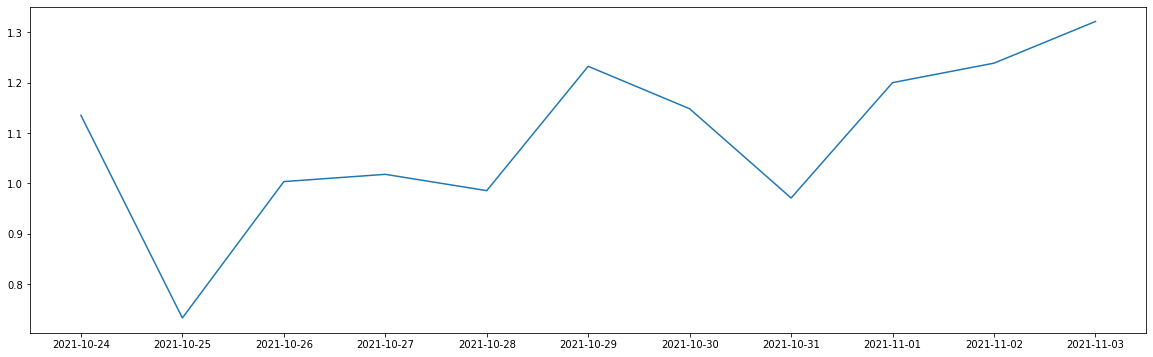

In [17]:
from generative_model_metrics import get_vector_correlation_over_time

df_hindcast["day"] = df_hindcast["time"].apply(lambda x: x[:10])
df_vec_corr = get_vector_correlation_over_time(df_hindcast)

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(df_vec_corr["day"], df_vec_corr["vec_corr"], label="Vector Correlation")

# needed to supress most labels
every_nth = 1
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.show()

### Plot Spatial Error

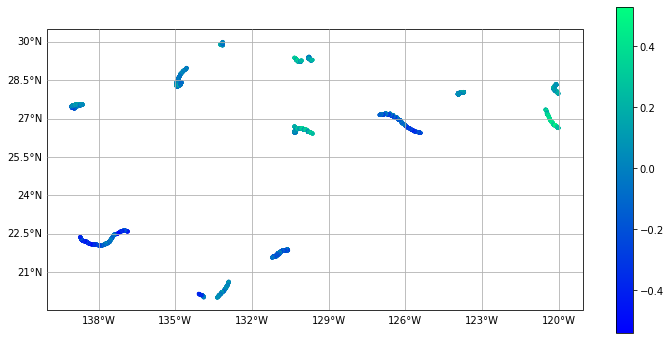

In [19]:
# spatial plot of error
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
grid_lines = ax.gridlines(draw_labels=True, zorder=5)
grid_lines.top_labels = False
grid_lines.right_labels = False
ax.add_feature(cfeature.LAND, zorder=3, edgecolor='black')

plt.scatter(df_hindcast["lon"], df_hindcast["lat"], c=(df_hindcast["v"]-df_hindcast["v_hindcast"]), marker=".", cmap="winter")
plt.colorbar()
plt.show()

Plot above is for an area of 500 km by 984 km

### Generate Plots for HYCOM Hindcast

In [1]:
def get_time_index(time: str) -> int:
    t_origin = dateutil.parser.isoparse("2018-12-05T07:00:00Z")
    t_desired = dateutil.parser.isoparse(time)
    t_difference = t_desired - t_origin
    t_index = int((t_difference.days*24 + t_difference.seconds/3600)/3)
    return t_index

def get_lat_index(lat: float) -> int:
    lat_origin = 2000
    if lat < 0:
        return 2000 - int(abs(lat/0.04))
    else:
        return 2000 + int(abs(lat/0.04))

def get_lon_index(lon: float) -> int:
    if lon < 0:
        lon += 360
    return 0 + int(lon/0.08)

def get_hycom_hindcast(time_range, lat_range, lon_range):
    dataset_link = "https://tds.hycom.org/thredds/dodsC/GLBy0.08/expt_93.0"
    time = f"[{get_time_index(time_range[0])}:{get_time_index(time_range[1])}]"
    lat = f"[{get_lat_index(lat_range[0])}:{get_lat_index(lat_range[1])}]"
    lon = f"[{get_lon_index(lon_range[0])}:{get_lon_index(lon_range[1])}]"
    total_index_str = f"{time}[0:39]{lat}{lon}"
    return xr.open_dataset(f"{dataset_link}?water_u{total_index_str},water_v{total_index_str}")

ds = get_hycom_hindcast(["2021-01-01T00:00:00Z","2021-01-31T00:00:00Z"], [25,30], [-130,-120])
# dataset_link = "https://tds.hycom.org/thredds/dodsC/GLBy0.08/expt_93.0"
# ds = xr.open_dataset(dataset_link, decode_times=False)

print(ds["water_u"].values[0,:,0,0])

## Plot Errors for Forecast

In [16]:
# Create the source dict for the ocean currents
source_dict = {'field': 'OceanCurrents'}
source_dict['source'] = 'forecast_files'
source_dict['source_settings'] = {"folder": "/home/jonas/Documents/Thesis/OceanPlatformControl/data/drifter_data/forecast_test/"}

sim_cache_dict = {'deg_around_x_t': 1, 'time_around_x_t': 3600 * 24 * 1}

# load forecast
ocean_field = OceanCurrentField(hindcast_source_dict=source_dict, sim_cache_dict=sim_cache_dict)
ds_forecast = ocean_field.forecast_data_source.DataArray
ds_forecast

Forecast is the same as Hindcast for OceanCurrents.


<xarray.Dataset>
Dimensions:  (lon: 661, lat: 301, time: 228)
Coordinates:
  * lon      (lon) float32 -160.0 -159.9 -159.8 -159.8 ... -105.2 -105.1 -105.0
  * lat      (lat) float32 15.0 15.08 15.17 15.25 ... 39.75 39.83 39.92 40.0
  * time     (time) datetime64[ns] 2022-04-24T12:30:00 ... 2022-05-03T23:30:00
    depth    float32 0.494
Data variables:
    water_u  (time, lat, lon) float32 ...
    water_v  (time, lat, lon) float32 ...
Attributes: (12/19)
    product:                       GLOBAL_ANALYSIS_FORECAST_PHY_001_024
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    title:                         hourly mean merged surface currents from o...
    area:                          GLOBAL
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    Conventions:                   CF-1.6
    ...                            ...
    institution:                   MERCATOR OCEAN
    julian_day_unit:               hours since 1950-01-01 00:00:00
    latitude_min:                  -80
    latitude_max:                  90.0
    longitude_min:                 -180.0
    longitude_max:                 179.91667175293

In [73]:
buoy_data.interpolate_forecast(ocean_field)

100%|██████████| 706/706 [00:06<00:00, 104.76it/s]

Percentage of failed interp: 0.0%


,time,lon,lat,u,v,buoy,u_hind,v_hind,u_forecast,v_forecast
0,2022-04-24 13:00:00,-123.538,21.458,-0.016,-0.029,GL_TS_DC_3201843_202204,-0.171278,-0.036249,-0.172965,-0.036119
1,2022-04-24 14:00:00,-123.539,21.455,-0.061,-0.015,GL_TS_DC_3201843_202204,-0.155447,-0.044254,-0.163119,-0.043646
2,2022-04-24 15:00:00,-123.538,21.454,-0.108,0.043,GL_TS_DC_3201843_202204,-0.140914,-0.053249,-0.154339,-0.052814
3,2022-04-24 16:00:00,-123.535,21.450,-0.139,0.116,GL_TS_DC_3201843_202204,-0.130486,-0.060468,-0.144769,-0.060586
4,2022-04-24 17:00:00,-123.530,21.445,-0.170,0.144,GL_TS_DC_3201843_202204,-0.119433,-0.064652,-0.134480,-0.060181
...,...,...,...,...,...,...,...,...,...,...
7048,2022-05-03 09:00:00,-135.035,28.503,0.046,-0.271,GL_TS_DC_5501571_202205,-0.078591,-0.100608,0.094757,-0.051938
7049,2022-05-03 10:00:00,-135.044,28.504,0.062,-0.245,GL_TS_DC_5501571_202205,-0.071954,-0.113381,0.103498,-0.068979
7050,2022-05-03 11:00:00,-135.052,28.507,0.047,-0.192,GL_TS_DC_5501571_202205,-0.058777,-0.118979,0.107777,-0.087820
7051,2022-05-03 12:00:00,-135.059,28.507,-0.016,-0.163,GL_TS_DC_5501571_202205,-0.048609,-0.117959,0.111458,-0.103807


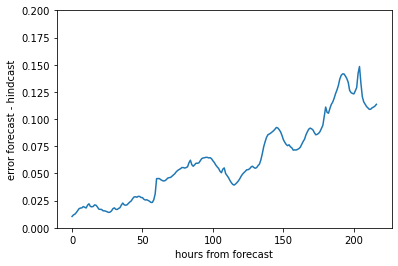

In [74]:
from generative_model_metrics import calc_speed_RMSE

# take RMSE to find error over every time step
rmse = pd.DataFrame(columns=["time", "rmse"])
rmse["time"] = sorted(list(set(buoy_data.data["time"].astype(str).tolist())))
rmse_metric = []
for timestamp in rmse["time"].tolist():
    df_temp = buoy_data.data[buoy_data.data["time"] == timestamp]
    rmse_points = calc_speed_RMSE(df_temp["u_forecast"], df_temp["v_forecast"], df_temp["u_hind"], df_temp["v_hind"])
    rmse_metric.append(np.mean(rmse_points))

rmse["rmse"] = rmse_metric
rmse["time"] = pd.to_datetime(rmse["time"])
first_datetime = rmse["time"].iloc[0]
rmse["hours"] = rmse["time"].apply(lambda x: pd.Timedelta((x - first_datetime)).seconds/3600 + pd.Timedelta((x - first_datetime)).days*24)
plt.plot(rmse["hours"], rmse["rmse"])
plt.ylim([0,0.2])
plt.xlabel("hours from forecast")
plt.ylabel("error forecast - hindcast")
plt.show()

In [36]:
# Vis location of bbox
lon_range = [min(ds_forecast["lon"].values), max(ds_forecast["lon"].values)]
lat_range = [min(ds_forecast["lat"].values), max(ds_forecast["lat"].values)]
print(lon_range)
x_loc = (sum(lon_range))/2
y_loc = (sum(lat_range))/2
f = folium.Figure(width=500, height=500)
m = folium.Map(location=[y_loc, x_loc], zoom_start=3).add_to(f)
points = [(lat_range[0], lon_range[0]), (lat_range[1], lon_range[1])]
folium.Rectangle(bounds=points, color='#ff7800').add_to(m)
f

[-160.0, -105.0]


In [37]:
# create dataframe which combines buoy data with interpolated forecast
df_forecast = buoy_data.interpolate_forecast(ocean_field)
df_forecast

100%|██████████| 723/723 [00:05<00:00, 142.52it/s]

Percentage of failed interp: 0.0%


,time,lon,lat,u,v,buoy,u_hind,v_hind
410,2022-04-24 13:00:00,-123.538002,21.458000,-0.016,-0.029,GL_TS_DC_3201843_202204,-0.172966,-0.036120
411,2022-04-24 14:00:00,-123.539001,21.455000,-0.061,-0.015,GL_TS_DC_3201843_202204,-0.163120,-0.043647
412,2022-04-24 15:00:00,-123.538002,21.454000,-0.108,0.043,GL_TS_DC_3201843_202204,-0.154340,-0.052815
413,2022-04-24 16:00:00,-123.535004,21.450001,-0.139,0.116,GL_TS_DC_3201843_202204,-0.144771,-0.060588
414,2022-04-24 17:00:00,-123.529999,21.445000,-0.170,0.144,GL_TS_DC_3201843_202204,-0.134479,-0.060180
...,...,...,...,...,...,...,...,...
11401,2022-04-30 19:00:00,-134.574005,28.533001,NaN,NaN,GL_TS_DC_5501571,-0.034082,0.106938
11402,2022-04-30 20:00:00,-134.585007,28.532000,NaN,NaN,GL_TS_DC_5501571,-0.027743,0.083108
11403,2022-04-30 21:00:00,-134.597000,28.530001,NaN,NaN,GL_TS_DC_5501571,-0.018483,0.061637
11404,2022-04-30 22:00:00,-134.606003,28.528000,NaN,NaN,GL_TS_DC_5501571,-0.021692,0.039230


In [38]:
from generative_model_metrics import calc_speed_mean, calc_speed_RMSE, plot_metric, get_vector_correlation_over_time

df_forecast["RMSE_speed"] = calc_speed_RMSE(df_forecast["u_hind"], df_forecast["v_hind"], df_forecast["u"], df_forecast["v"])
df_forecast["mean_speed"] = calc_speed_mean(df_forecast["u_hind"], df_forecast["v_hind"], df_forecast["u"], df_forecast["v"])

In [39]:
# filter out NaN values
df_forecast = df_forecast[df_forecast["RMSE_speed"].isna() == False]
df_forecast.shape

(7053, 10)

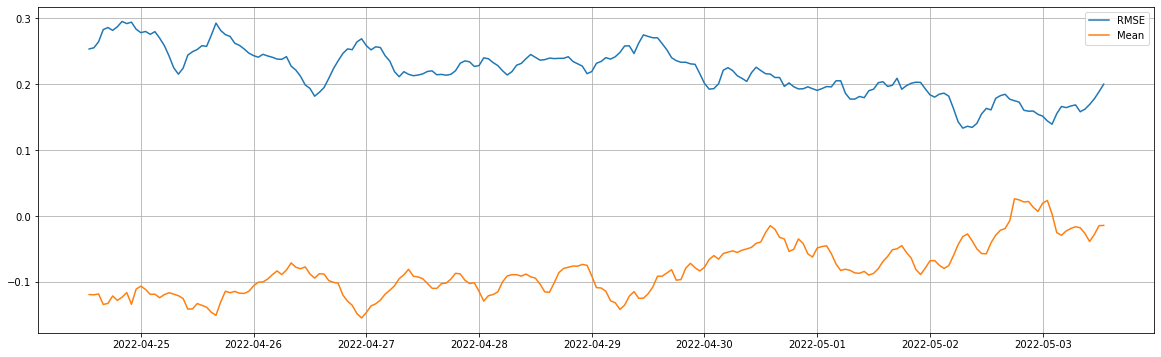

In [40]:
# mean current error vs time
df_group = df_forecast.groupby(by=["time"], as_index=False).mean()
fig, ax = plt.subplots(figsize=(20,6))
plt.locator_params(axis='x', nbins=7)
plt.plot(df_group["time"], df_group["RMSE_speed"], label="RMSE")
plt.plot(df_group["time"], df_group["mean_speed"], label="Mean")
plt.legend()
plt.grid()

# needed to supress most labels
every_nth = 1
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.show()

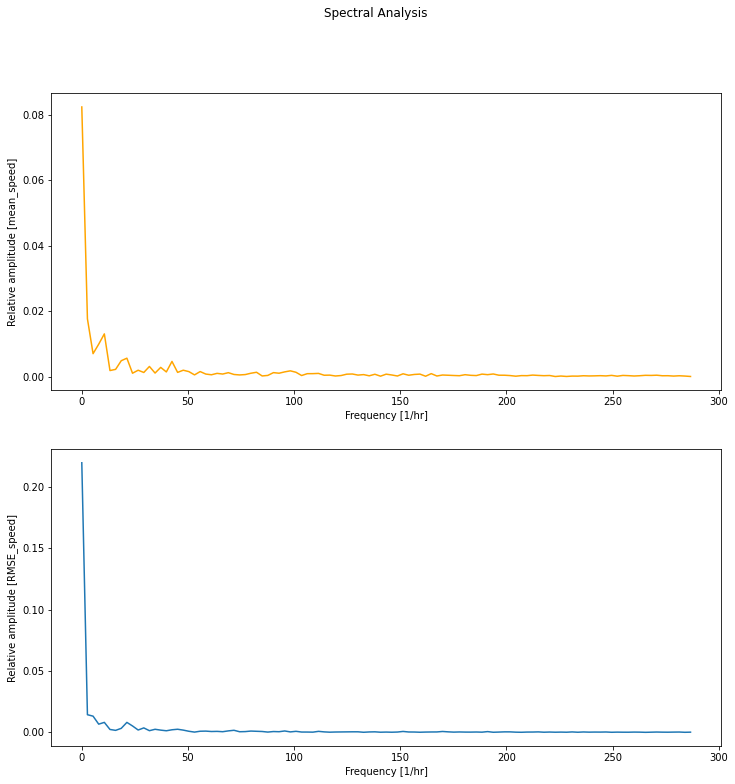

In [41]:
# spectral analysis
from scipy.fft import fft, rfftfreq

fig, axs = plt.subplots(2, figsize=(12,12))
fig.suptitle("Spectral Analysis")

metric = "mean_speed"
n = len(df_group[metric])
sample_rate = 24 # measurements per day
fourier_transform = np.fft.rfft(df_group[metric])/n
frequencies = rfftfreq(n, 1/sample_rate)
axs[0].plot(frequencies*24, abs(fourier_transform), color="orange")
axs[0].set_xlabel('Frequency [1/hr]')
axs[0].set_ylabel(f'Relative amplitude [{metric}]')

metric = "RMSE_speed"
n = len(df_group[metric])
sample_rate = 24 # measurements per day
fourier_transform = np.fft.rfft(df_group[metric])/n
frequencies = rfftfreq(n, 1/sample_rate)
axs[1].plot(frequencies*24, abs(fourier_transform))
axs[1].set_xlabel('Frequency [1/hr]')
axs[1].set_ylabel(f'Relative amplitude [{metric}]')

plt.show()

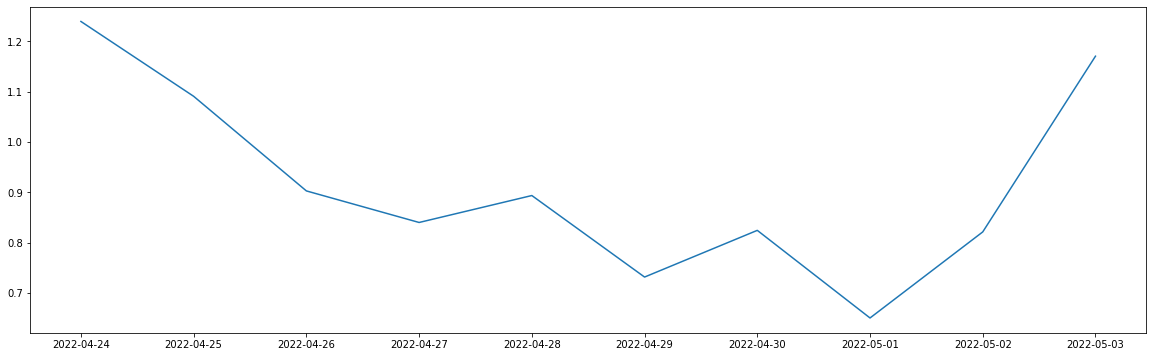

In [42]:
df_forecast["time"] = df_forecast["time"].astype(str)
df_forecast["day"] = df_forecast["time"].apply(lambda x: x[:10])
df_vec_corr = get_vector_correlation_over_time(df_forecast)

plot_metric(df_vec_corr["day"], df_vec_corr["vec_corr"], supress_nth_label=1)

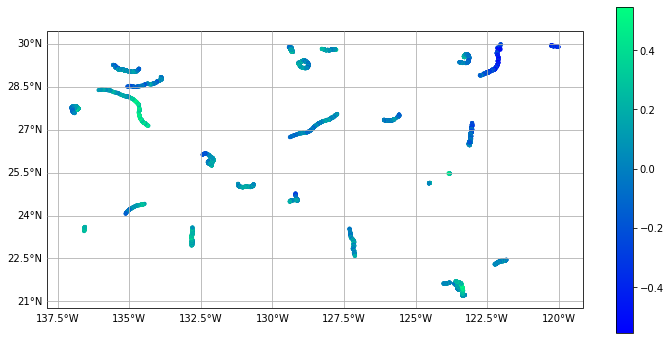

In [44]:
# spatial plot of error
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
grid_lines = ax.gridlines(draw_labels=True, zorder=5)
grid_lines.top_labels = False
grid_lines.right_labels = False
ax.add_feature(cfeature.LAND, zorder=3, edgecolor='black')

plt.scatter(df_forecast["lon"], df_forecast["lat"], c=(df_forecast["u"]-df_forecast["u_hind"]), marker=".", cmap="winter")
plt.colorbar()
plt.show()